# Sentiment Analysis for Amazon Book Reviews and Analysing the Data Based on Genres 
![](http://images4.alphacoders.com/132/1326368.png)

This notebook is a project that tries to identify any meaningful patterns in sentiment analysis for Amazon Book Reviews based on differences in Genres.
- The dataset used is Amazon Books Reviews ([Click Here](http://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data?select=books_data.csv)).
- Parts of this project for sentiment analysis take inspiration from [here](https://www.kaggle.com/code/robikscube/sentiment-analysis-python-youtube-tutorial#Plot-VADER-results).

The project includes the following:
1. Read the separate datasets and combine into one workable dataframe having only the required features.
2. Load and use Roberta Pretrained Model from huggingface for sentiment analysis.
3. Use matplotlib.pyplot and seaborn to visualize results.

## STEPS
* **Importing Libraries**
* **Creating Usable DataFrame**
* **Importing Roberta Pretrained Model**
* **Executing Sentiment Analysis for DataFrame**
* **Visualizing the Results** 
* **Genres Based Analysis**

## Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background') 

## Creating Usable DataFrame

The books_data.csv file is read and converted to pandas dataframe. All the columns except Title and Categories are dropped as those two are the only columns needed.
Similarly a dataframe is made for Books_rating.csv as it contains the actual reviews.
Lastly, a final dataframe is made by combining the dataframes to include both categories and review in a single dataframe.

In [2]:
df = pd.read_csv("/kaggle/input/amazon-books-reviews/books_data.csv")
print(df.shape)

(212404, 10)


In [3]:
df.columns

Index(['Title', 'description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'categories', 'ratingsCount'],
      dtype='object')

In [4]:
df = df.drop(columns = ['description', 'authors', 'image', 'previewLink', 'publisher',
       'publishedDate', 'infoLink', 'ratingsCount'])

In [5]:
df.set_index("Title")
print(df.shape)
df.head()

(212404, 2)


,Title,categories
0,Its Only Art If Its Well Hung!,['Comics & Graphic Novels']
1,Dr. Seuss: American Icon,['Biography & Autobiography']
2,Wonderful Worship in Smaller Churches,['Religion']
3,Whispers of the Wicked Saints,['Fiction']
4,"Nation Dance: Religion, Identity and Cultural ...",NaN


In [6]:
df2 = pd.read_csv("/kaggle/input/amazon-books-reviews/Books_rating.csv")


In [7]:
print(df2.shape)
df2.columns

(3000000, 10)


Index(['Id', 'Title', 'Price', 'User_id', 'profileName', 'review/helpfulness',
       'review/score', 'review/time', 'review/summary', 'review/text'],
      dtype='object')

In [8]:
df2 = df2.drop(columns = ['Id', 'Price', 'User_id', 'profileName', 'review/helpfulness', 'review/time', 'review/summary'])

In [9]:
df2.head()

,Title,review/score,review/text
0,Its Only Art If Its Well Hung!,4.0,This is only for Julie Strain fans. It's a col...
1,Dr. Seuss: American Icon,5.0,I don't care much for Dr. Seuss but after read...
2,Dr. Seuss: American Icon,5.0,"If people become the books they read and if ""t..."
3,Dr. Seuss: American Icon,4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,Dr. Seuss: American Icon,4.0,Philip Nel - Dr. Seuss: American IconThis is b...


### Combining the dataframes

In [10]:
col = "Title"
df2 = df.join(df2.set_index(col), on=col)

In [11]:
del df
print(df2.shape)

(3000000, 4)


In [12]:
df2 = df2.reset_index(drop = True)
df2.index.rename("ID", inplace = True)
df2 = df2.reset_index()
df2.head()

,ID,Title,categories,review/score,review/text
0,0,Its Only Art If Its Well Hung!,['Comics & Graphic Novels'],4.0,This is only for Julie Strain fans. It's a col...
1,1,Dr. Seuss: American Icon,['Biography & Autobiography'],5.0,I don't care much for Dr. Seuss but after read...
2,2,Dr. Seuss: American Icon,['Biography & Autobiography'],5.0,"If people become the books they read and if ""t..."
3,3,Dr. Seuss: American Icon,['Biography & Autobiography'],4.0,"Theodore Seuss Geisel (1904-1991), aka &quot;D..."
4,4,Dr. Seuss: American Icon,['Biography & Autobiography'],4.0,Philip Nel - Dr. Seuss: American IconThis is b...


The above snippet is run to create a new ID column to match the ID later in the result dataframe.

In [13]:
df2 = df2.dropna()
print(df2.shape)

(2448496, 5)


This removes the data without catergories, score, or review, which are all required for this project.

## Preliminary Data View
This is to analyze the distribution of data based on "review/score" or star rating (1-5)

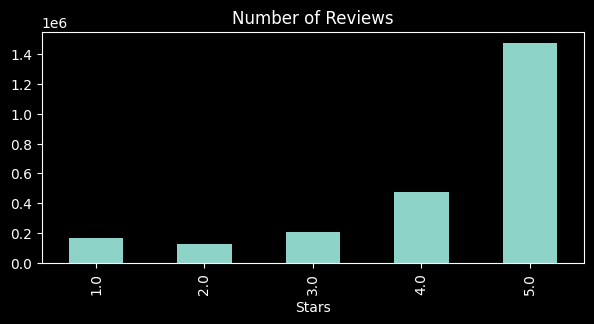

In [14]:
ax = df2['review/score'].value_counts().sort_index().plot( \
            kind='bar',
            title='Number of Reviews',
            figsize=(7, 3))
ax.set_xlabel('Stars')
plt.show()

## Importing Transformers and Roberta Pretrained Model

In [15]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax

In [16]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment" 
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


### Testing the model on one example

In [17]:
test = df2["review/text"][0]
print(test)

This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the place to find it -- there's only about 2 pages with text and everything else is photos.Bottom line: if you only want one book, the Six Foot One ... is probably a better choice, however, if you like Julie like I like Julie, you won't go wrong on this one either.


In [18]:
en_text = tokenizer(test, return_tensors='pt')
res = model(**en_text)
scores = softmax(res[0][0].detach().numpy())

sent_dict = {
    'Negative' : scores[0],
    'Neutral' : scores[1],
    'Positive' : scores[2]
}
print(sent_dict)

{'Negative': 0.029945545, 'Neutral': 0.28565794, 'Positive': 0.6843965}


### Creating a Function for Sentiment Analysis

Using the code above, the function sent_score is made. It accepts the text for sentiment analysis and returns a dictionary for individual scores.

In [19]:
def sent_score(test):
    en_text = tokenizer(test, return_tensors='pt')
    res = model(**en_text)
    scores = softmax(res[0][0].detach().numpy())

    sent_dict = {
        'Negative' : scores[0],
        'Neutral' : scores[1],
        'Positive' : scores[2]
    }
    return(sent_dict)

### Importing tqdm for progress visualization 

In [20]:
from tqdm.notebook import tqdm

*Limiting the dataset size for faster execution!! The model can be used to analyze all the data resulting in better evaluation, however, for demonstration purposes, it has been limited to first 2000 reviews. 

In [21]:
df2 = df2.head(2000)

## Executing Sentiment Analysis for DataFrame
The code below loops through the dataframe and yields sa_result dictionary which stores the ID and sentiment analysis score for the review for that ID. The list err_id stores all the IDs for which sentiment analysis raised errors. 

In [22]:
sa_result = {}
err_id = []
for i, row in tqdm(df2.iterrows(), total=len(df2)):
    try:
        review = row["review/text"]
        id_ = i
        res = sent_score(review)
        sa_result[id_] = res
    except (RuntimeError, IndexError) as e:
        err_id.append(id)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [23]:
print(f"Number of failed reviews: {len(err_id)}")

Number of failed reviews: 135


Combinging the resulting dataframe with original dataframe.

In [24]:
df_res = pd.DataFrame(sa_result).T
df_res = df_res.reset_index().rename(columns={'index': 'ID'})
df_res = df_res.merge(df2, how='left')
df_res.head()

,ID,Negative,Neutral,Positive,Title,categories,review/score,review/text
0,0,0.029946,0.285658,0.684397,Its Only Art If Its Well Hung!,['Comics & Graphic Novels'],4.0,This is only for Julie Strain fans. It's a col...
1,1,0.040939,0.265157,0.693904,Dr. Seuss: American Icon,['Biography & Autobiography'],5.0,I don't care much for Dr. Seuss but after read...
2,2,0.001396,0.029631,0.968973,Dr. Seuss: American Icon,['Biography & Autobiography'],5.0,"If people become the books they read and if ""t..."
3,4,0.068486,0.393222,0.538292,Dr. Seuss: American Icon,['Biography & Autobiography'],4.0,Philip Nel - Dr. Seuss: American IconThis is b...
4,5,0.061559,0.459627,0.478814,Dr. Seuss: American Icon,['Biography & Autobiography'],4.0,"""Dr. Seuss: American Icon"" by Philip Nel is a ..."


## Visualising the Results 
Seaborn library is imported to plot the result data.

In [25]:
import seaborn as sns

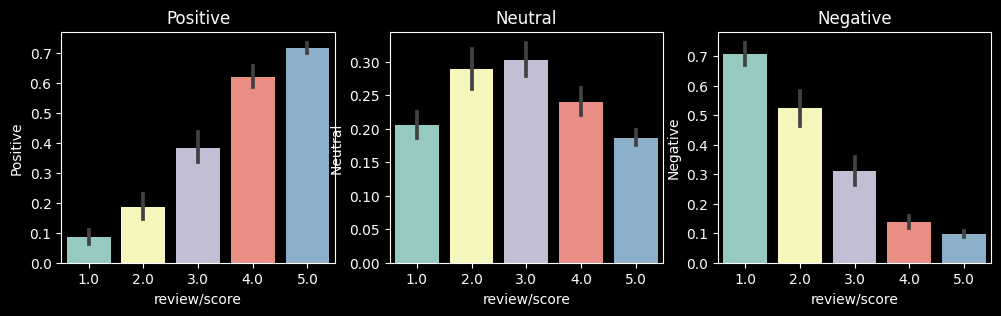

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=df_res, x='review/score', y='Positive', ax=axs[0])
sns.barplot(data=df_res, x='review/score', y='Neutral', ax=axs[1])
sns.barplot(data=df_res, x='review/score', y='Negative', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.show()

The above code plots all the resulting data based on sentiments against review/score. 

## Analysing Data Based on Genres

In [27]:
cats = df_res.categories.unique()
len(cats)

62

The code below loops through all the categories and plots the sentiment data of individual genre for analysis.

  0%|          | 0/62 [00:00<?, ?it/s]

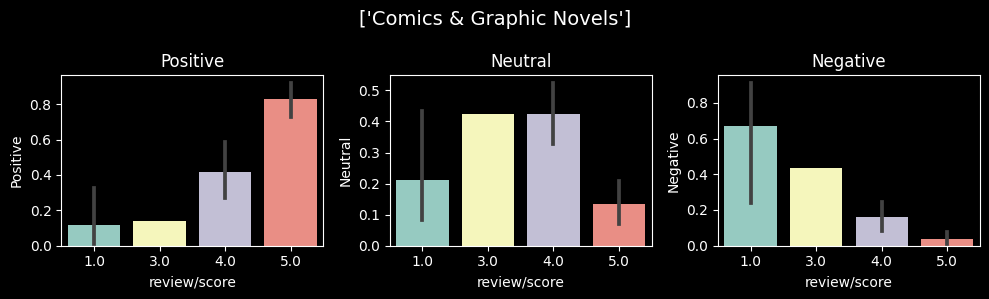

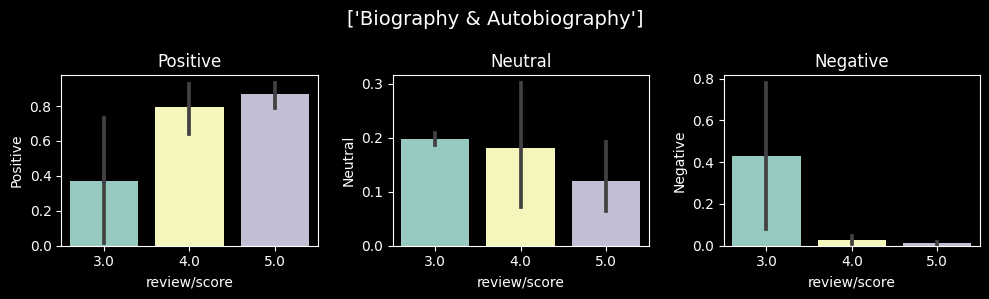

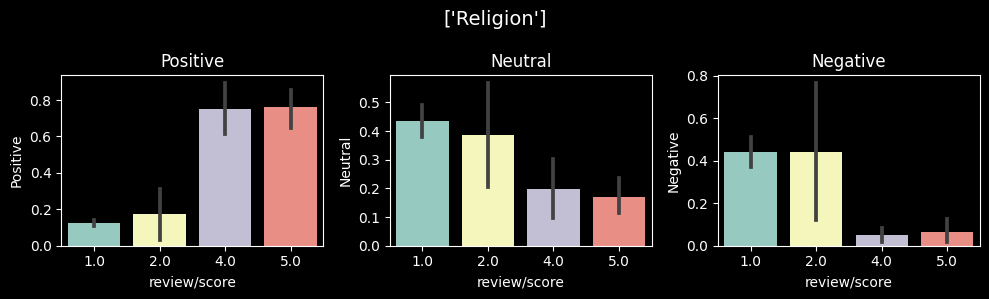

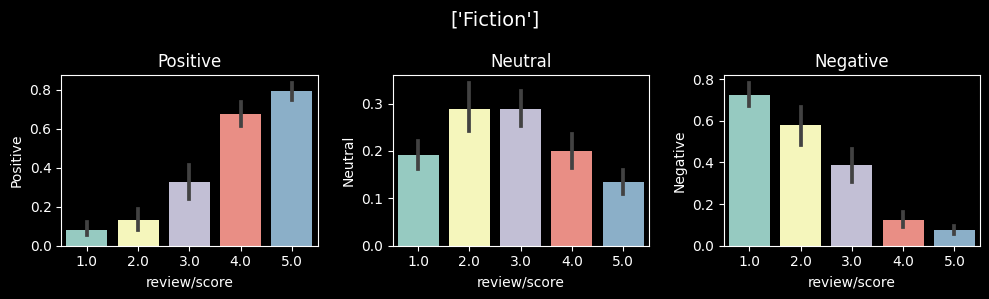

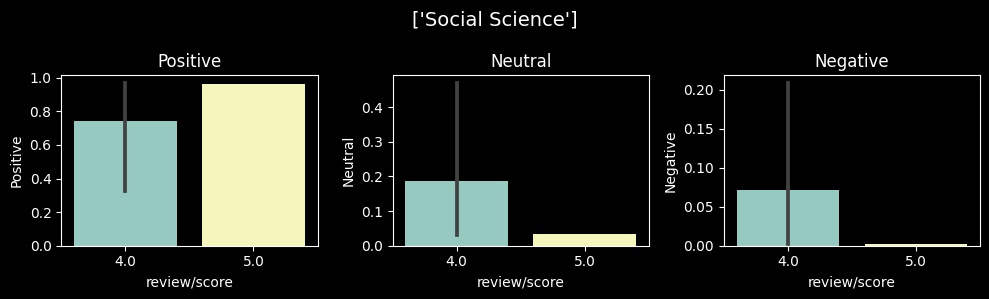

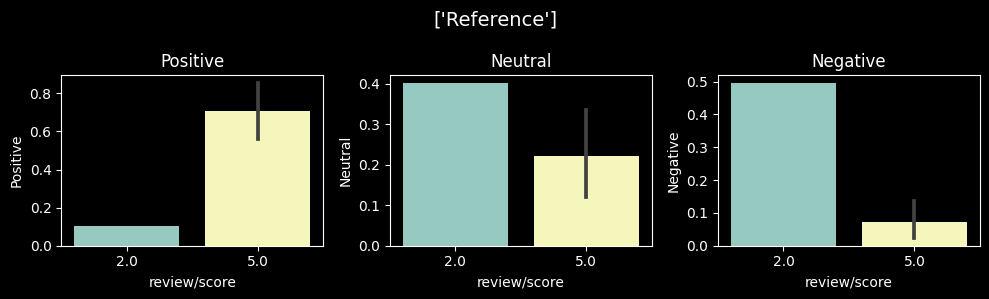

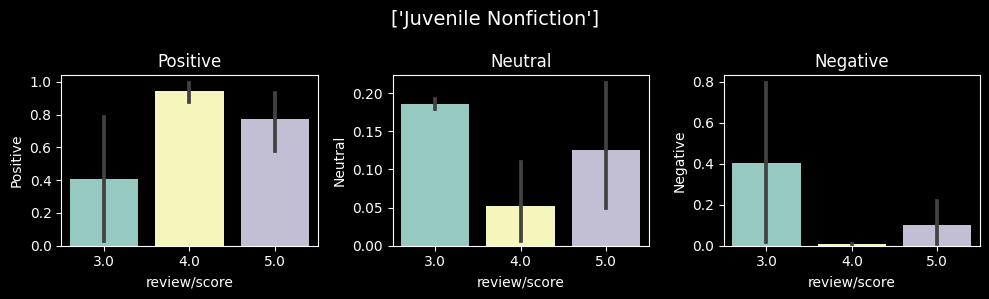

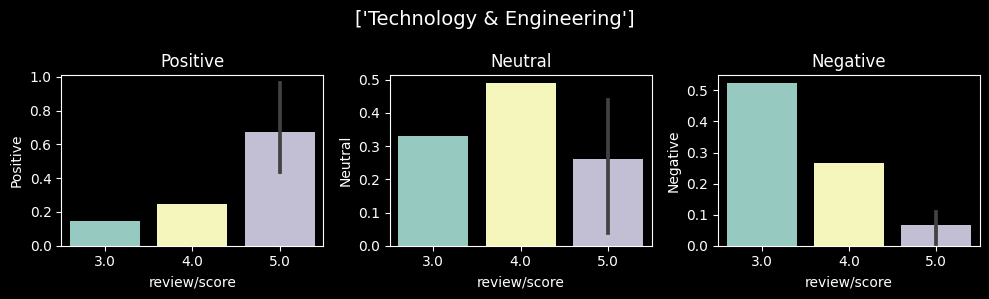

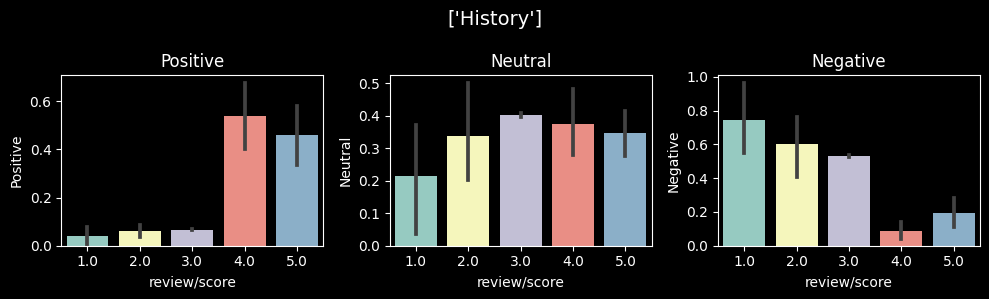

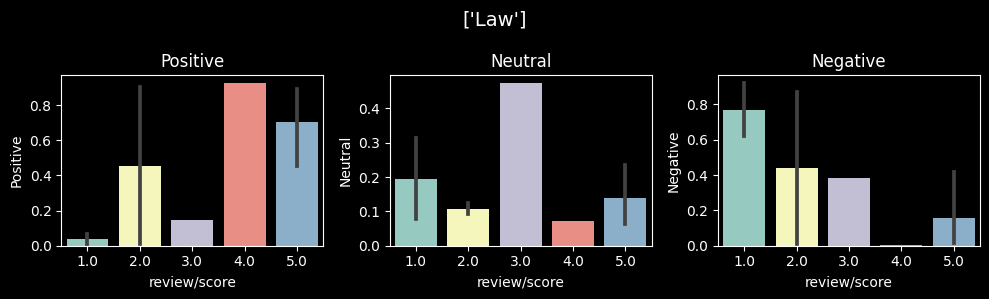

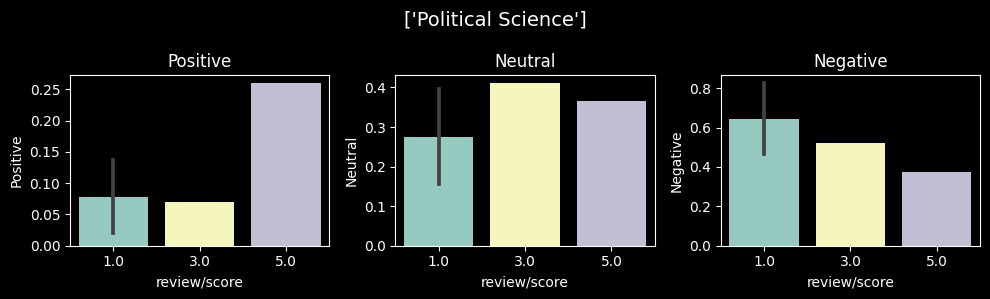

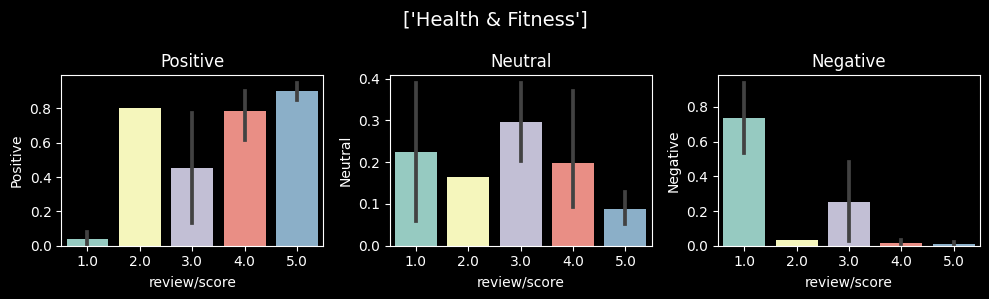

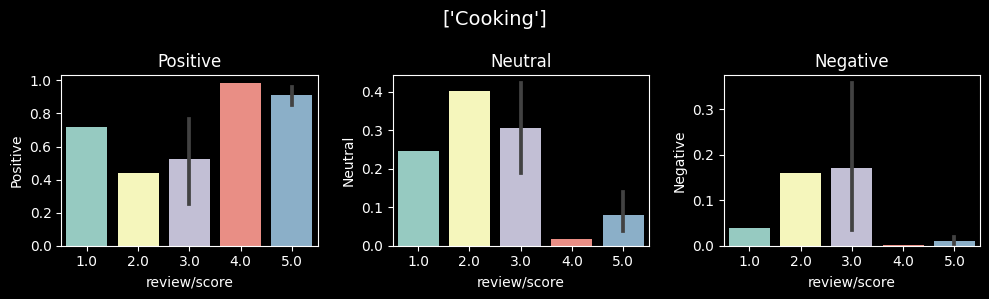

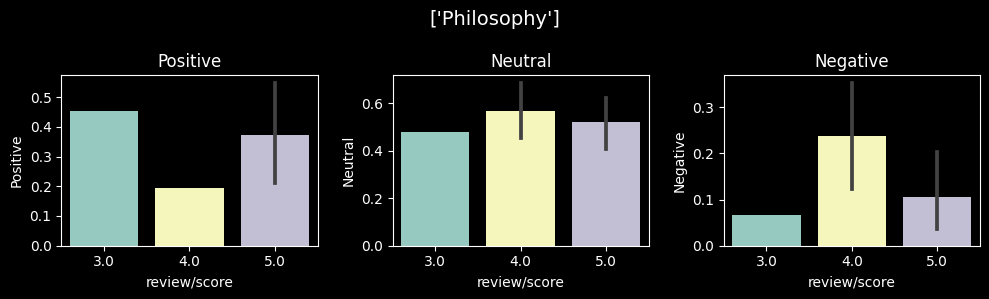

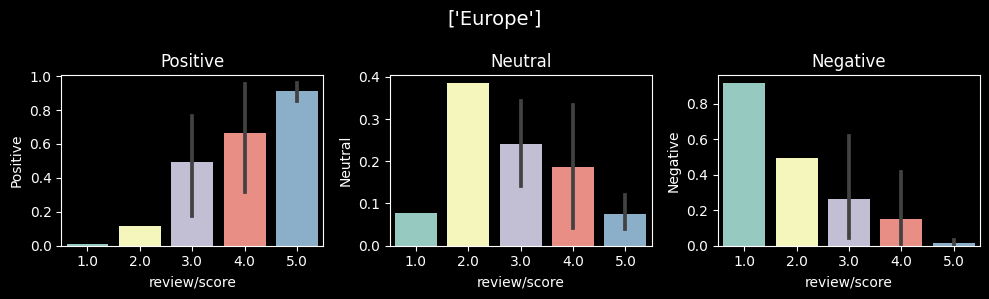

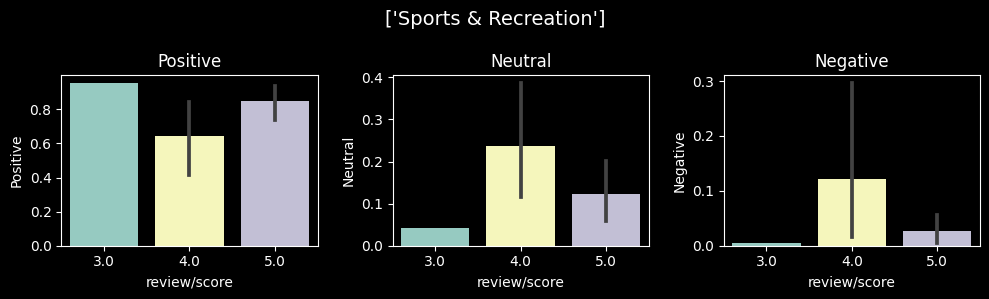

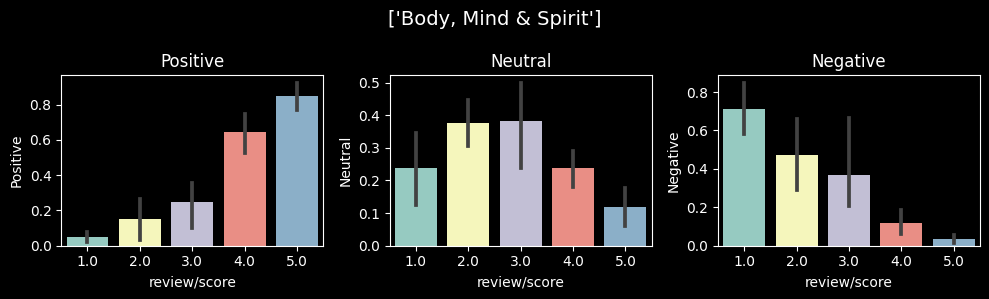

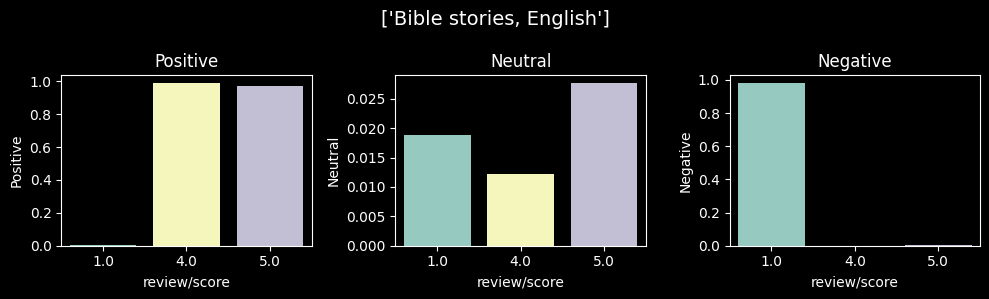

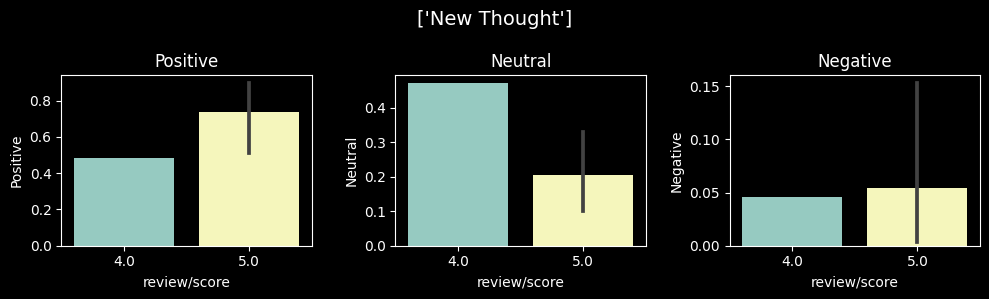

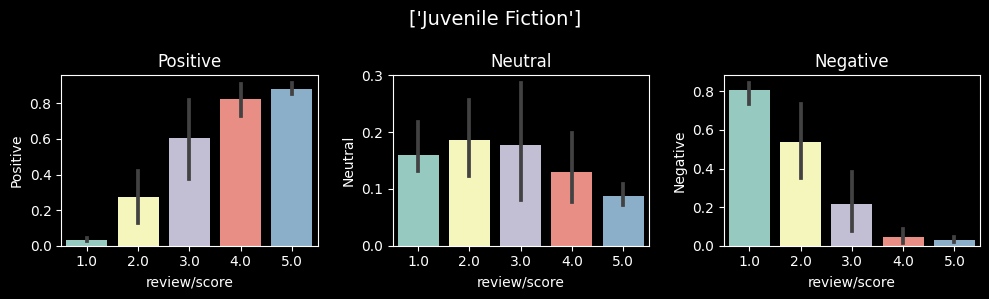

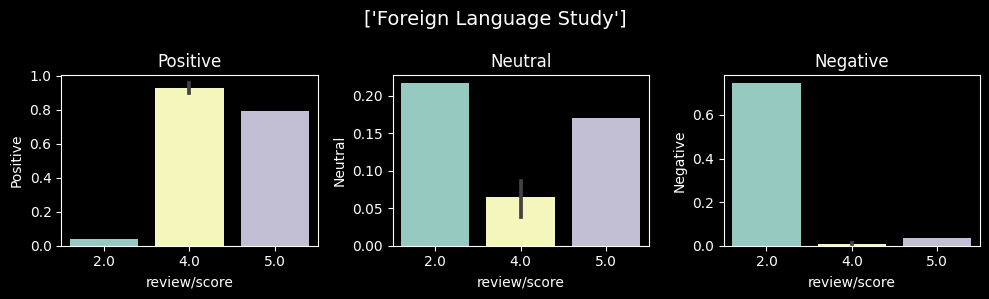

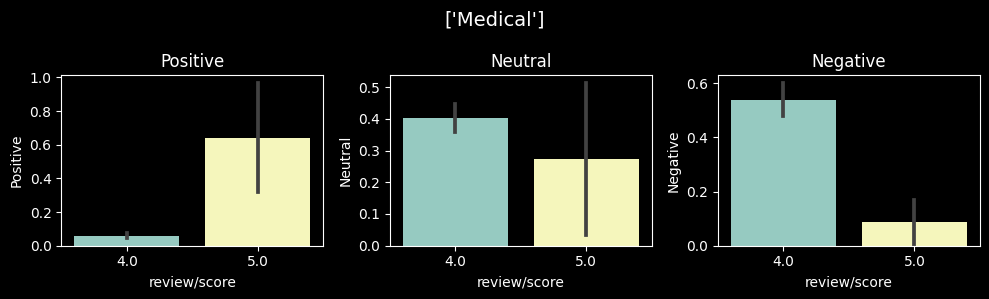

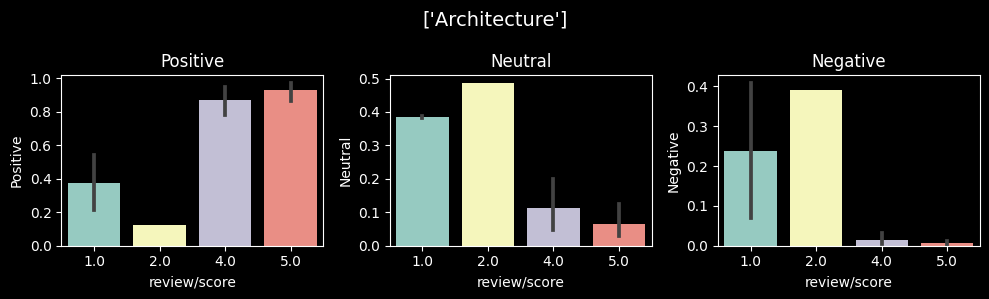

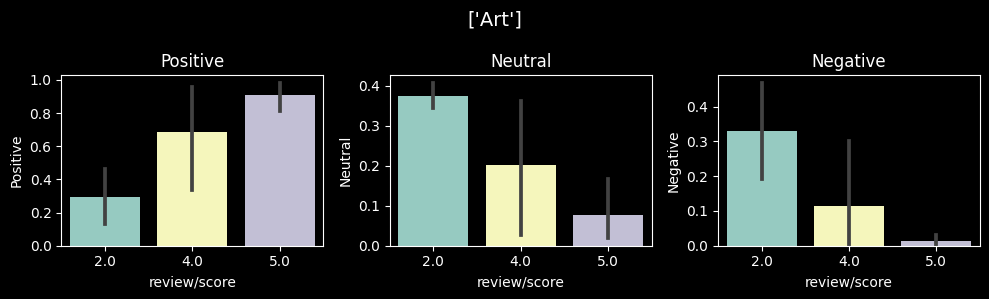

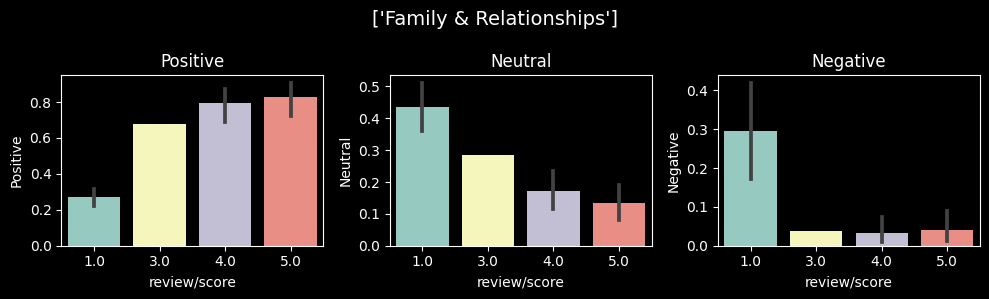

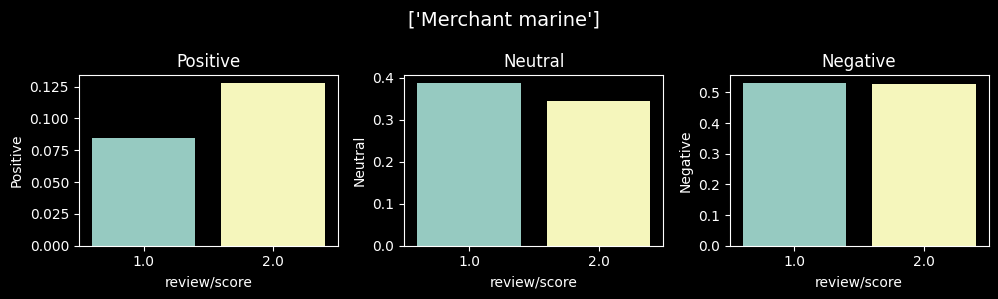

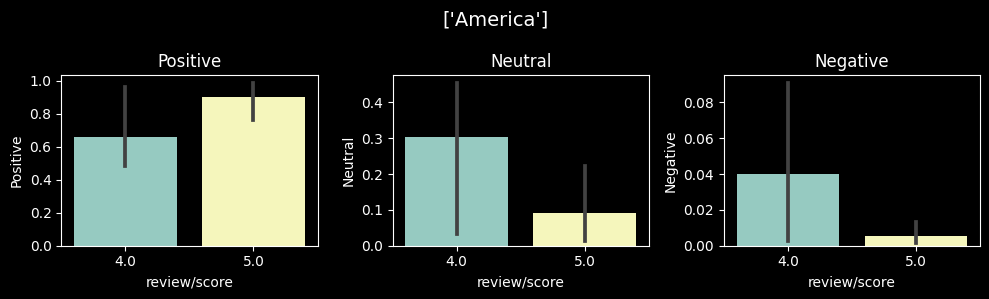

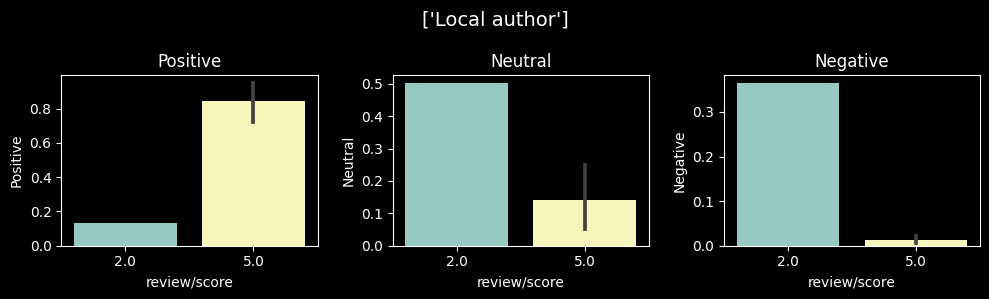

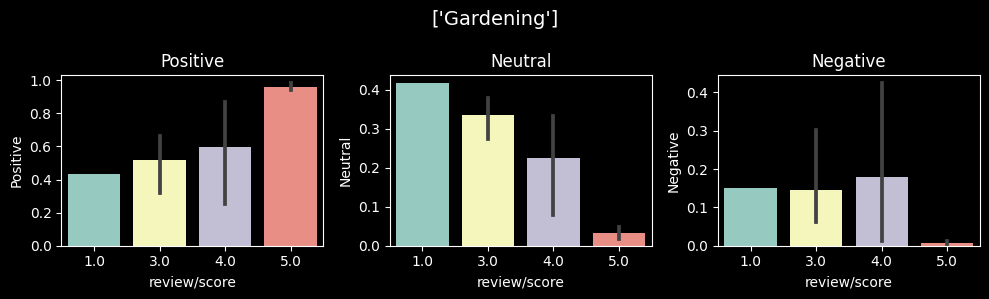

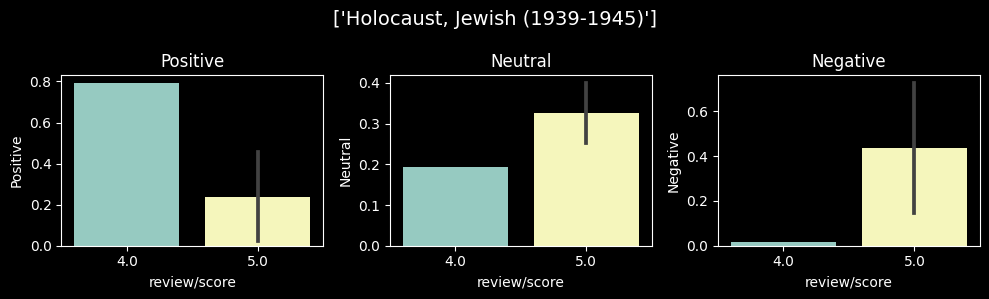

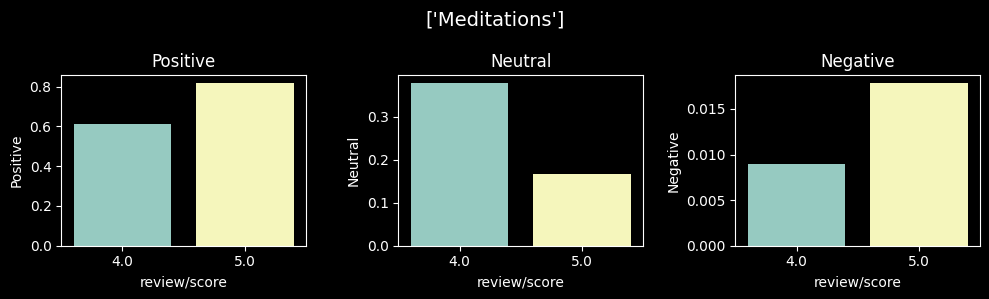

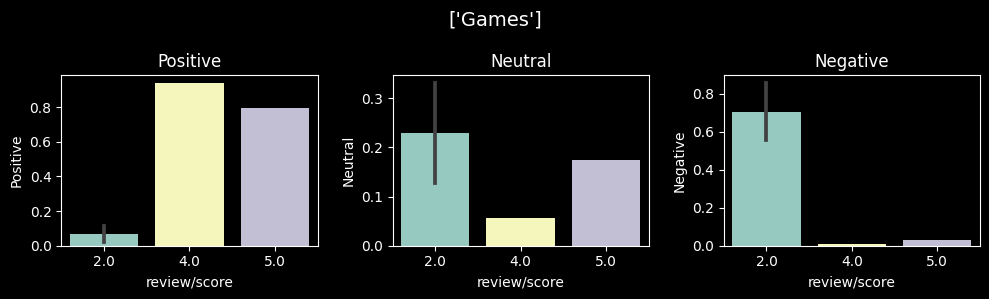

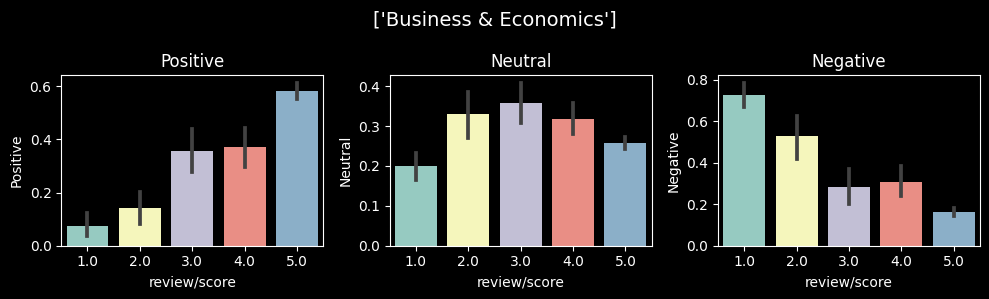

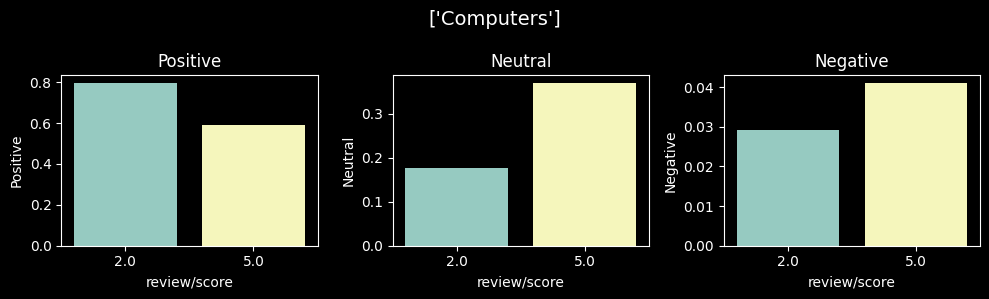

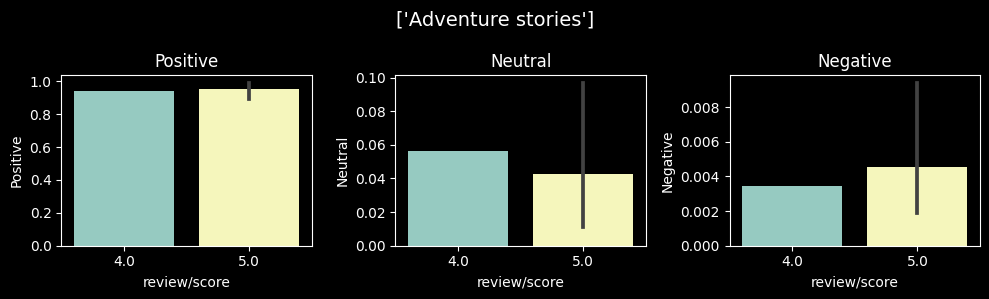

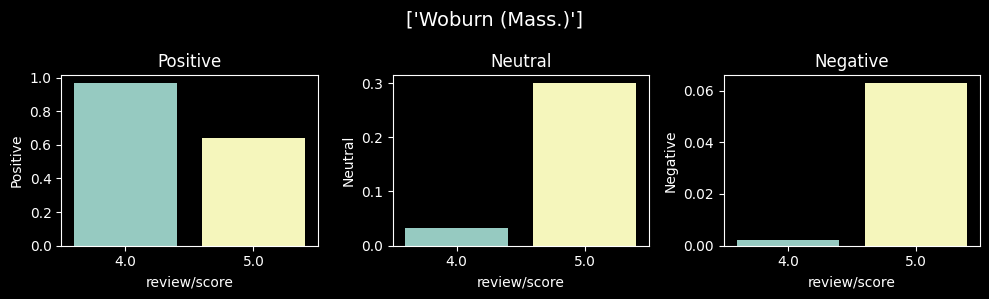

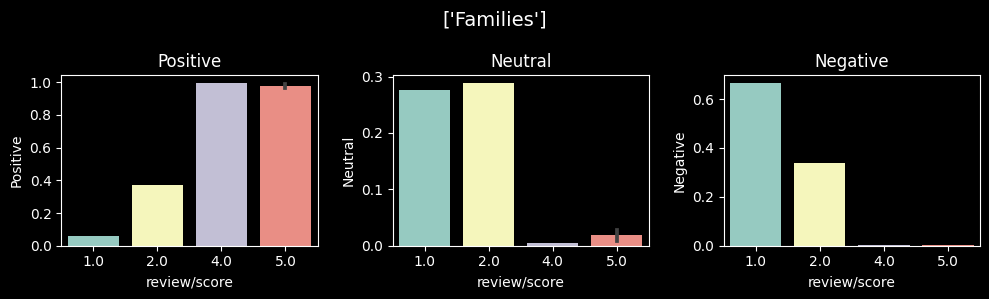

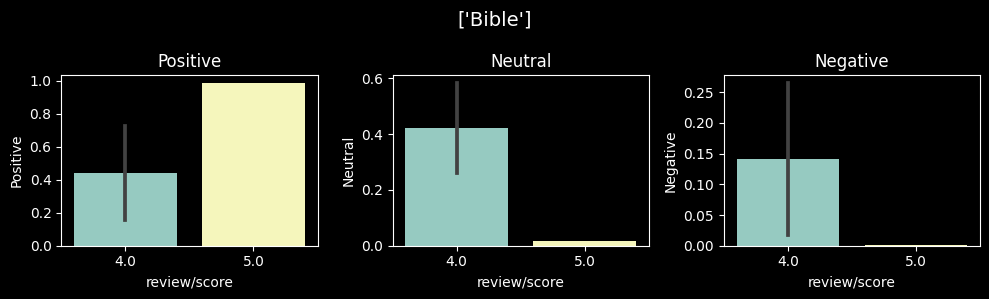

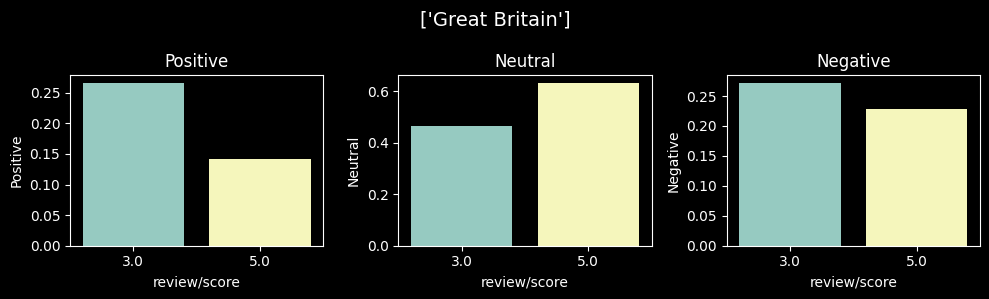

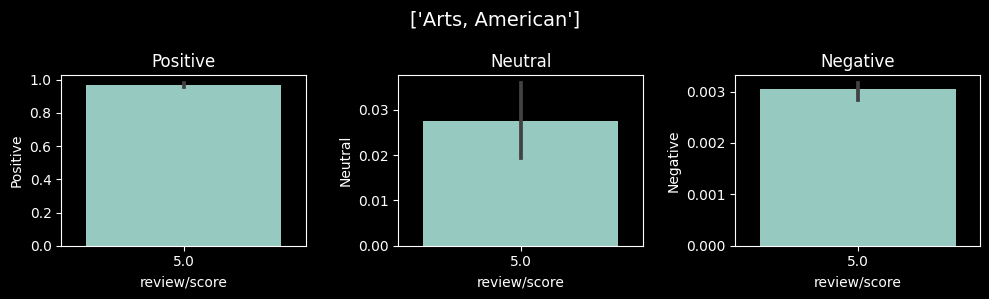

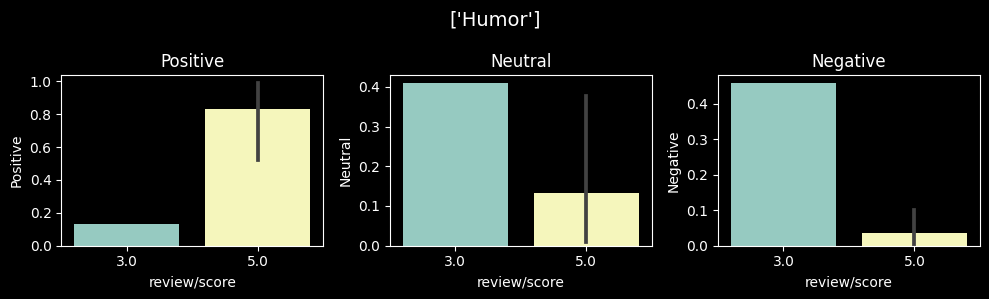

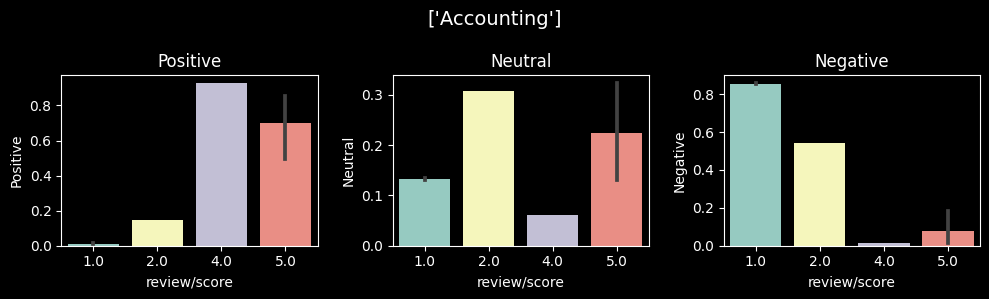

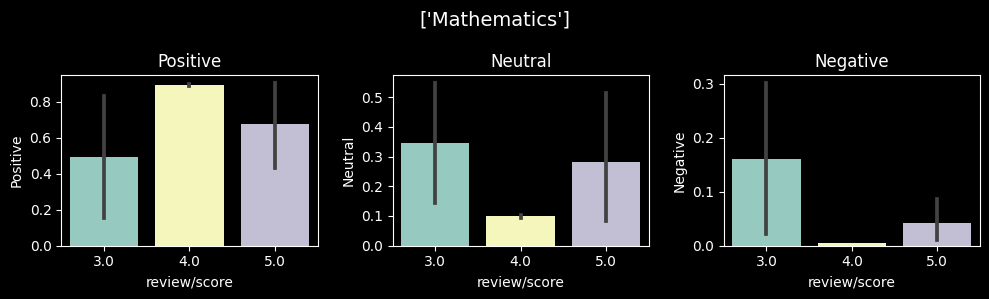

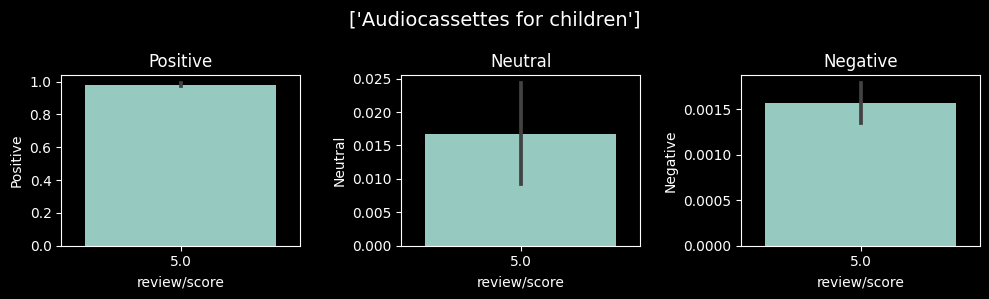

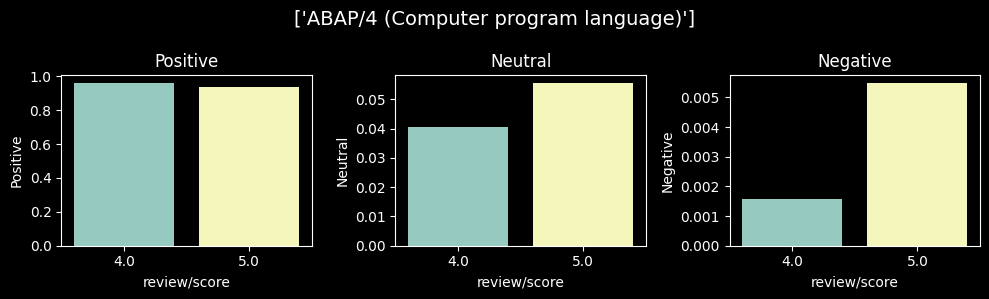

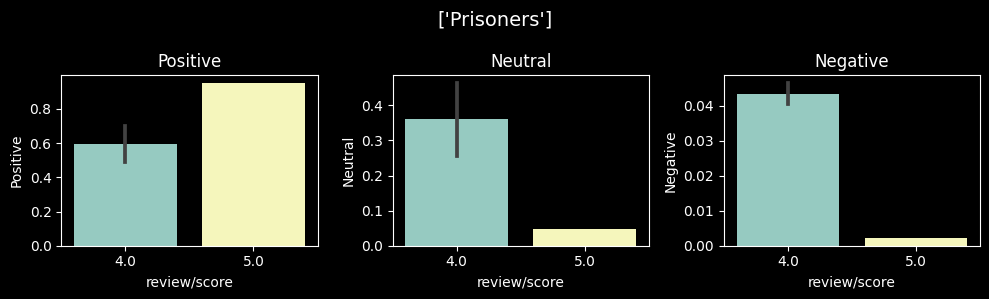

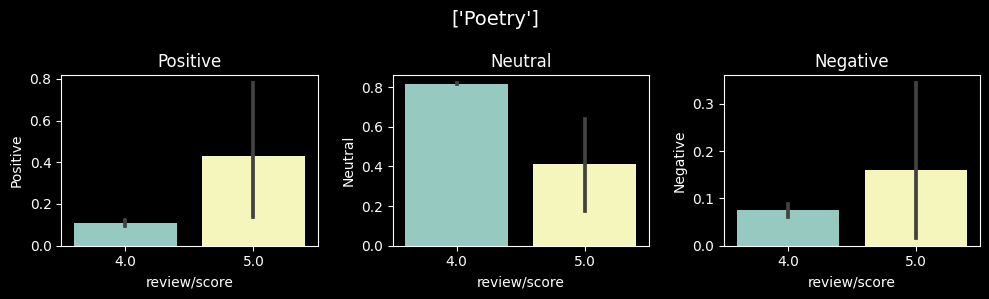

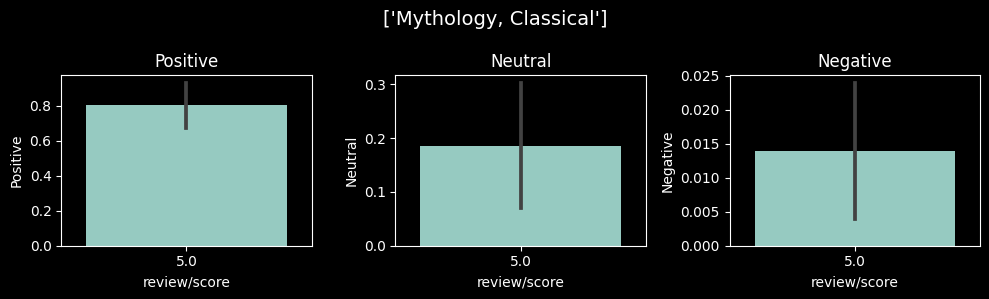

In [28]:
for cat in tqdm(cats, total=len(cats)):
    temp_df = df_res.loc[df_res['categories'] == cat]
    if len(temp_df)<2:
        continue
    fig, axs = plt.subplots(1, 3, figsize=(10, 3))
    sns.barplot(data=temp_df, x='review/score', y='Positive', ax=axs[0])
    sns.barplot(data=temp_df, x='review/score', y='Neutral', ax=axs[1])
    sns.barplot(data=temp_df, x='review/score', y='Negative', ax=axs[2])
    fig.suptitle(cat, fontsize=14)
    axs[0].set_title('Positive')
    axs[1].set_title('Neutral')
    axs[2].set_title('Negative')
    plt.tight_layout()
    plt.show()

## Determining Review Examples
- The most positive 1 star review and
- The most negative 5 star review

are printed for every genre for judgement.

In [29]:
for cat in tqdm(cats, total=len(cats)):
    try:
        temp_df = df_res.loc[df_res['categories'] == cat]
        if len(temp_df)<2:
            continue
        low = temp_df.query("`review/score` == 1.0").sort_values('Positive', ascending=False)['review/text'].values[0]
        high = temp_df.query("`review/score` == 5.0").sort_values('Negative', ascending=False)['review/text'].values[0]
        print(cat)
        print("\n1 star most Positive review -\n  ",low)
        print("5 star most Negative review -\n  ",high)
        print("\n")
    except IndexError:
        continue

  0%|          | 0/62 [00:00<?, ?it/s]

['Comics & Graphic Novels']

1 star most Positive review -
   This is the tale of a kindly Rabbi, his sweet daughter and the cat who loves her. The tale seems promising at first, until it delves into bitterness over God and those who love Him and follow His laws. The cat represents the glorification of sin itself, and delights whenever the book's characters fall into ungodly habits, judging them forever as hypocrites (taking no account into repentance and future avoidance of said sin). As is the case with most humanist literature the story down spirals from that point until it ends with the Rabbi losing faith in God. At this point the cat is truly happy with the Rabbi, thus giving the tale a 'happy ending'. In short, 'The Rabbi's Cat' is a tale structured to appeal to secular humanists, atheists and pagans who want to feel better about their self-serving, do as you feel, lifestyles.One more note: This book, despite the beautiful artwork and appealing cover, is definitely not appropriat